In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import numpy as np
from numpy import *
import matplotlib.image as mpimg

from PIL import Image
import os
import json
import cv2
from PIL import Image

import math
import io
import pandas as pd

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,TensorDataset

!pip install einops --quiet
import einops

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Master thesis/Sprites-master')

from scripts.utils import *
from scripts.data_loader import QuerySplit, DataUniqueSplit, QuerySplitTest
from scripts.model import CNNEncoder, VGG, ResidualBlock, ResNet, AspectBasedModel, DeepSetTraversalModule, DeepSetTraversalModuleResnet
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load data

In [2]:
#'Shapes' or 'Sprites'
dataset = 'Sprites'
images, df_attributes, support_size, images_train, images_val, images_test, attributes_train, \
    attributes_val, attributes_test, same_aspect, batch_size_train = load_data(dataset)

train_models = False

# Query separation



## Loader

In [3]:
batch_size_val = 16
transformations = transforms.Compose(
    [transforms.ToTensor()])

train_dataset = QuerySplit(attributes_train, df_attributes, images, same_aspect=same_aspect, data_queries=images_train, transform=transformations, support_size=support_size)
train_dataloader= DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=1)

val_dataset = DataUniqueSplit(attributes_val, df_attributes, images, same_aspect=same_aspect, data_queries = images_val, transform=transformations, support_size=support_size, train=False)
val_dataloader= DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, num_workers=1)

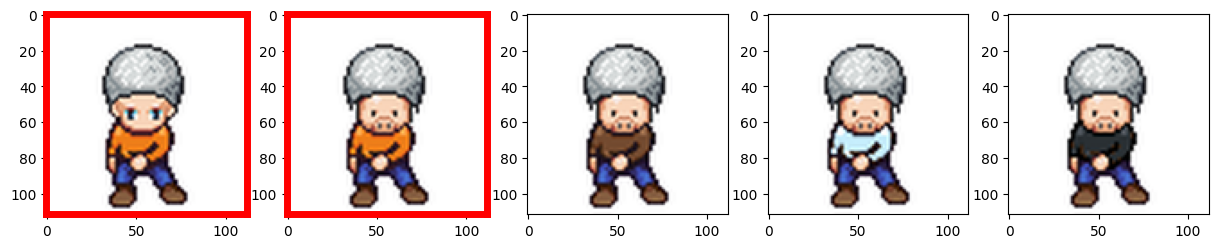

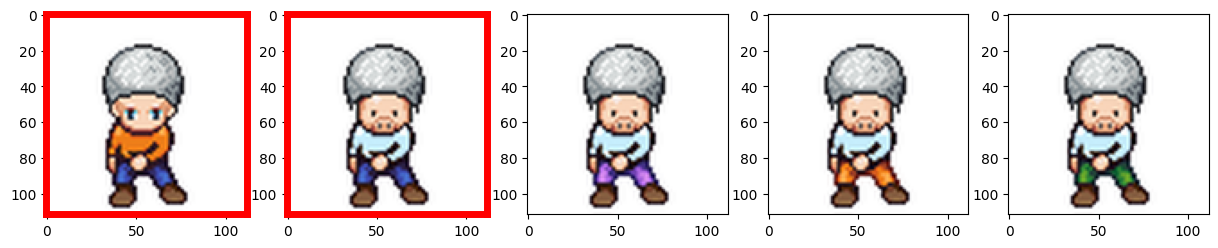

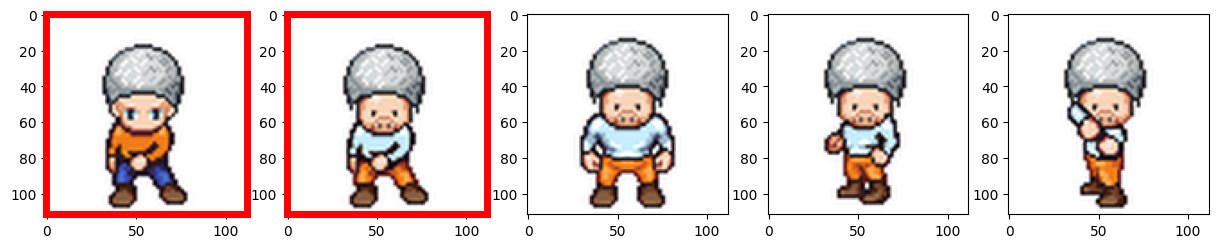

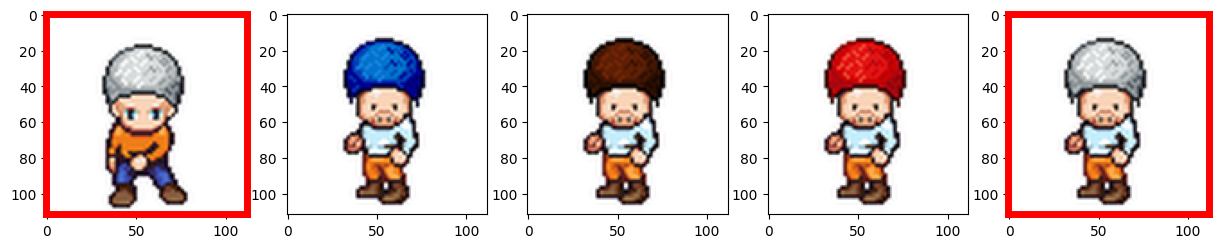

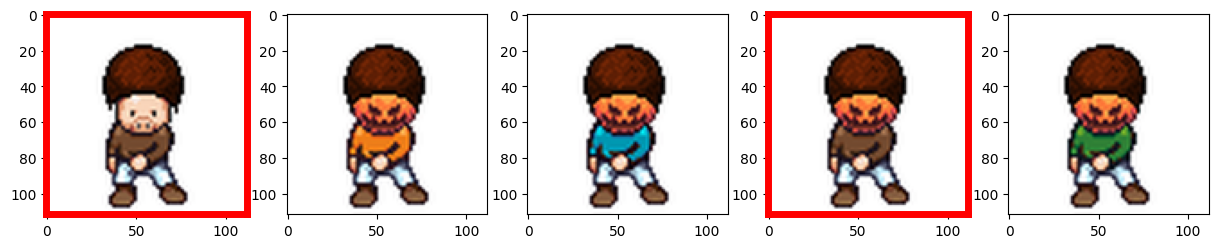

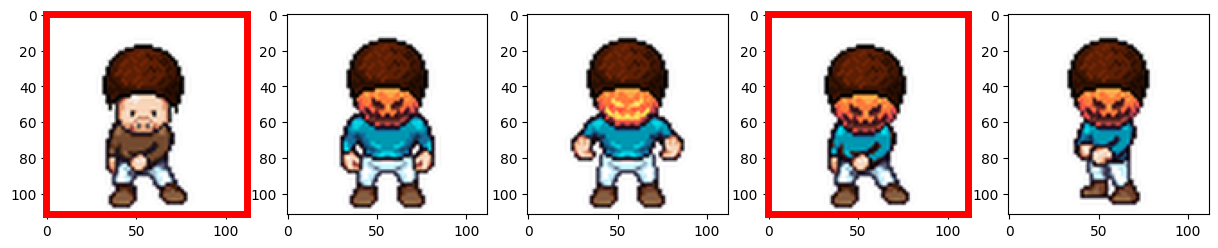

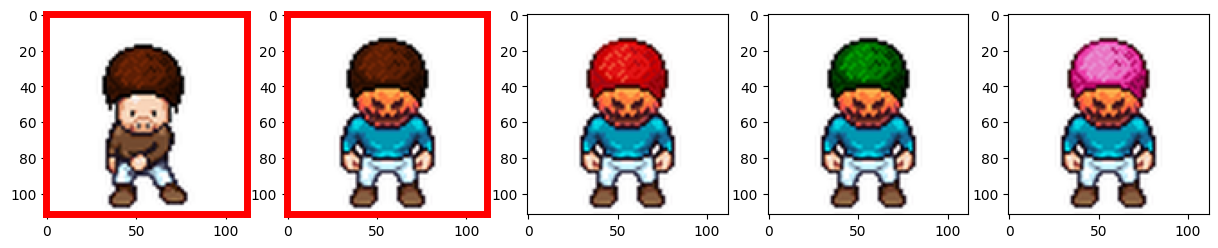

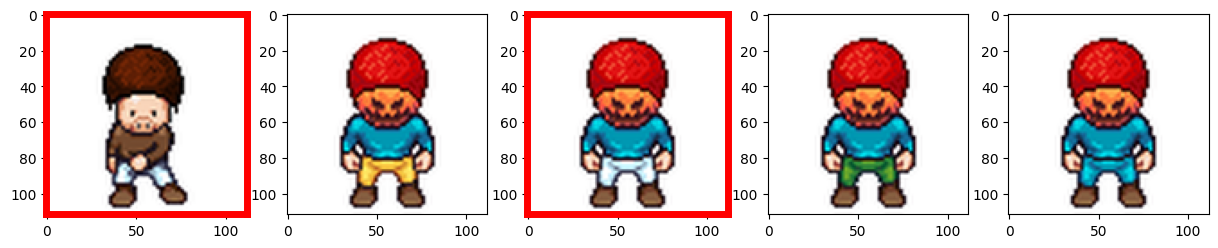

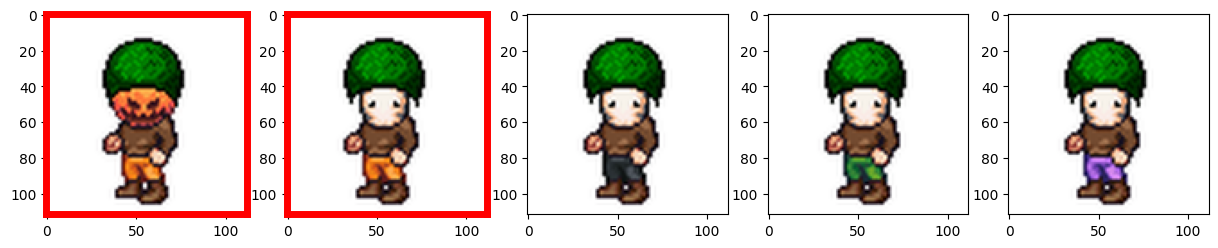

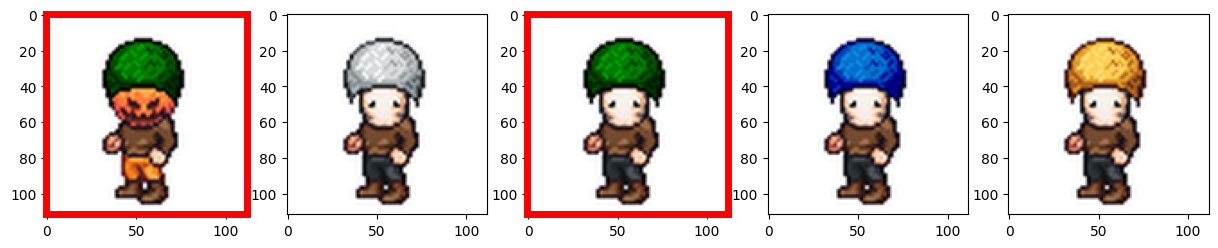

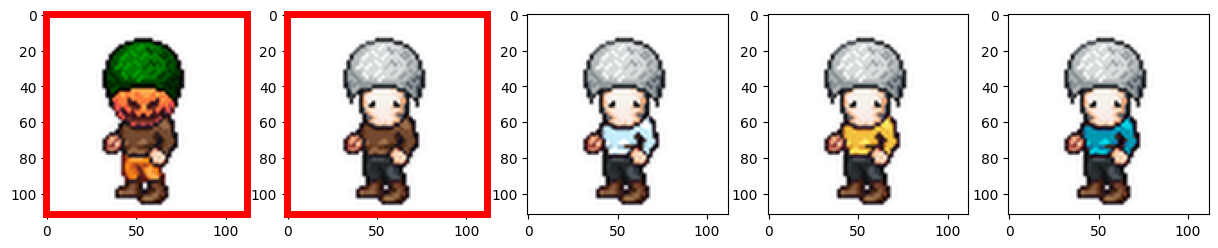

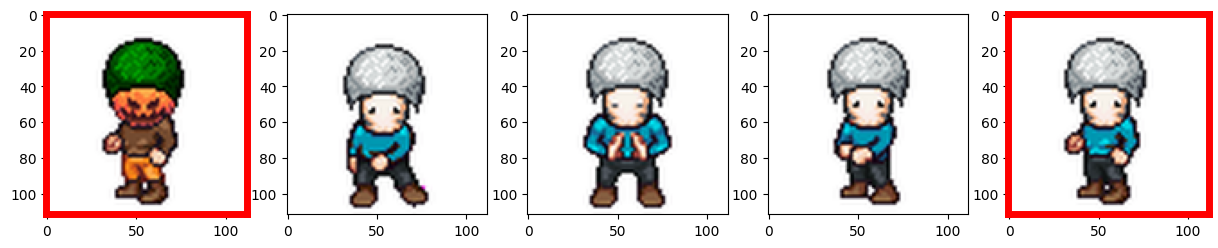

In [4]:
visualize_support_set(loader=train_dataloader, num_sets=3, support_size=support_size)

## Model


### training baseline

In [5]:
encoder = CNNEncoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name="model/" + dataset.lower() + " baseline.pt"

baseline = AspectBasedModel(represent_model=encoder, support_size=support_size)
baseline.to(device)

baseline.represent_model.requires_grad_(True)
optimizer = torch.optim.Adam(baseline.parameters(), lr=7e-4, weight_decay=1e-2)
criterion = AspectBasedTupletLoss(support_size, device=device)

In [6]:
if train_models:
  t_loss_context = train(baseline, train_dataloader, val_dataloader, 50, optimizer, criterion, model_name=model_name, device=device, support_size=support_size)
else:
  baseline.load_state_dict(torch.load(model_name, map_location=device))
  baseline.eval()

### training shallow shallow

In [7]:
encoder = CNNEncoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name="model/" + dataset.lower() + " shallow shallow.pt"

shallow_shallow = AspectBasedModel(represent_model=encoder, context_model = DeepSetTraversalModule, support_size=support_size)
shallow_shallow.to(device)

shallow_shallow.represent_model.requires_grad_(True)
optimizer = torch.optim.Adam(shallow_shallow.parameters(), lr=7e-4, weight_decay=1e-2)
criterion = AspectBasedTupletLoss(support_size, device=device)

In [8]:
if train_models:
  t_loss_context = train(shallow_shallow, train_dataloader, val_dataloader, 50, criterion, model_name=model_name)
else:
  shallow_shallow.load_state_dict(torch.load(model_name, map_location=device))
  shallow_shallow.eval()

### training VGG ResNet

In [9]:
encoder = VGG()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "model/" + dataset.lower() + " VGG resnet.pt"

VGG_resnet = AspectBasedModel(represent_model=encoder, context_model = DeepSetTraversalModuleResnet, support_size=support_size)
VGG_resnet.to(device)

VGG_resnet.represent_model.requires_grad_(True)
optimizer = torch.optim.Adam(VGG_resnet.parameters(), lr=7e-4, weight_decay=1e-2)
criterion = AspectBasedTupletLoss(support_size, device=device)

In [10]:
if train_models:
  t_loss_context = train(VGG_resnet, train_dataloader, val_dataloader, 50, criterion, model_name=model_name)
else:
  VGG_resnet.load_state_dict(torch.load(model_name, map_location=device))
  VGG_resnet.eval()

### training Resnet ResNet

In [11]:
encoder = ResNet(ResidualBlock, [1,1])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "model/" + dataset.lower() + " resnet resnet.pt"

ResNet_resnet = AspectBasedModel(represent_model=encoder, context_model = DeepSetTraversalModuleResnet, support_size=support_size)
ResNet_resnet.to(device)

ResNet_resnet.represent_model.requires_grad_(True)
optimizer = torch.optim.Adam(ResNet_resnet.parameters(), lr=7e-4, weight_decay=1e-2)
criterion = AspectBasedTupletLoss(support_size, device=device)

In [12]:
if train_models:
  t_loss_context = train(ResNet_resnet, train_dataloader, val_dataloader, 50, criterion, model_name=model_name)
else:
  ResNet_resnet.load_state_dict(torch.load(model_name, map_location=device))
  ResNet_resnet.eval()

# Data unique separation



## Loader

In [13]:
train_dataset = DataUniqueSplit(attributes_train, attributes_train, images_train, same_aspect=same_aspect, transform=transformations, support_size=support_size)
train_dataloader= DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=1)

val_dataset = DataUniqueSplit(attributes_val, df_attributes, images, data_queries = images_val, same_aspect=same_aspect, transform=transformations, support_size=support_size, train=False)
val_dataloader= DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, num_workers=1)

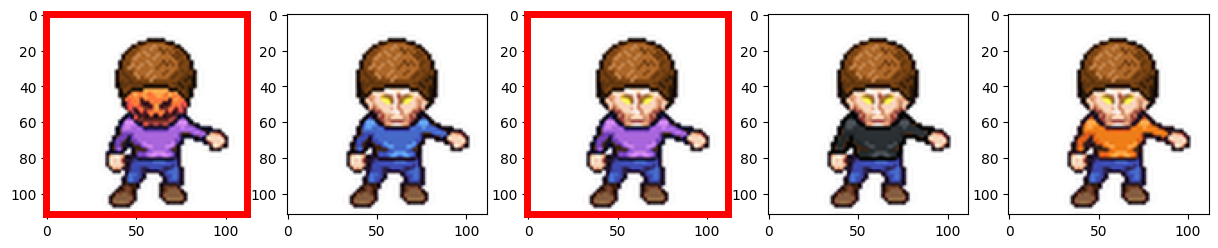

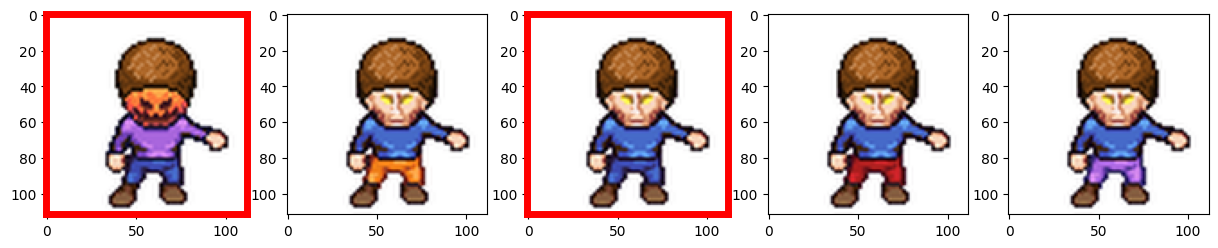

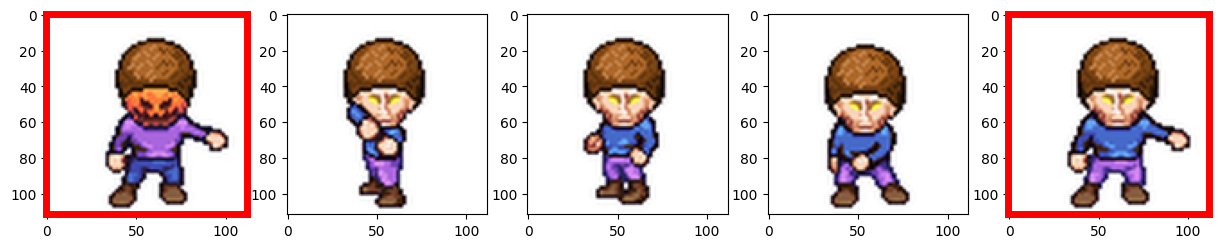

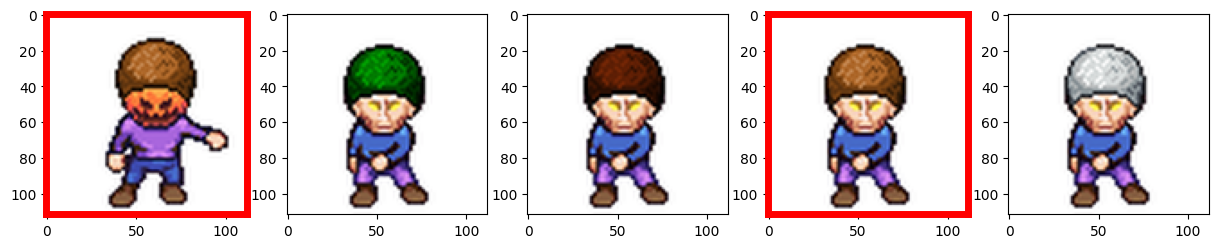

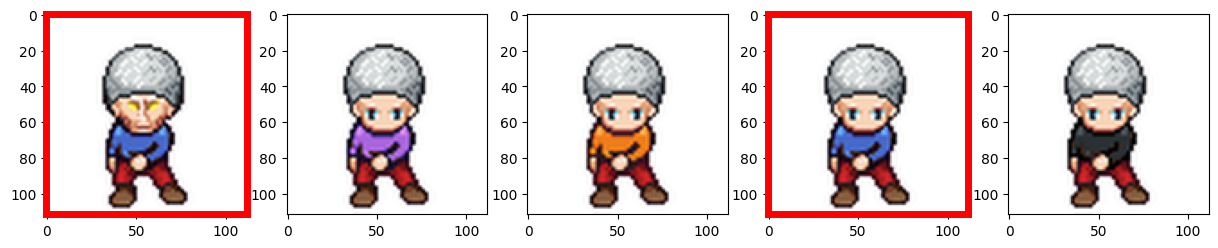

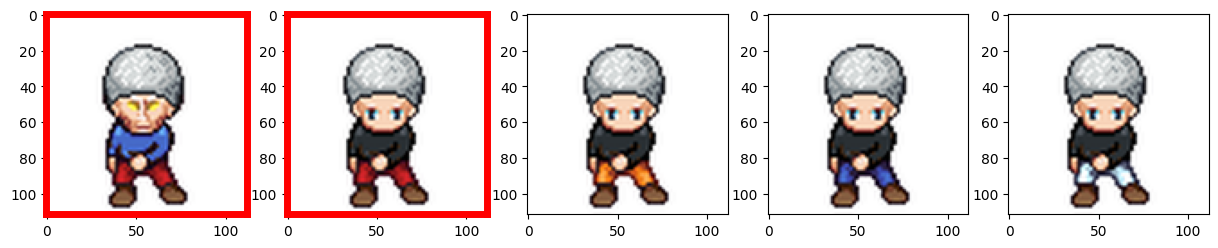

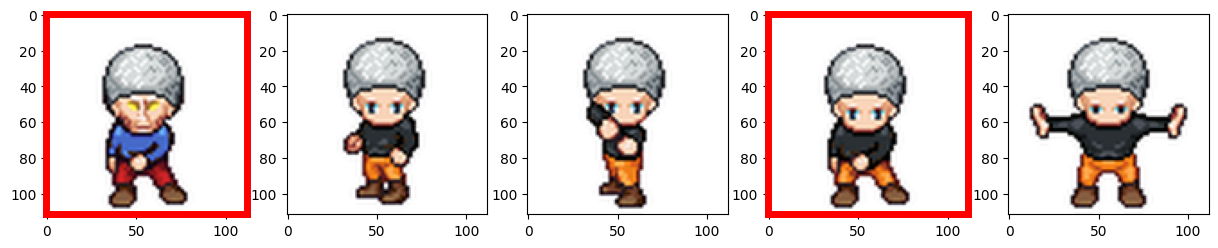

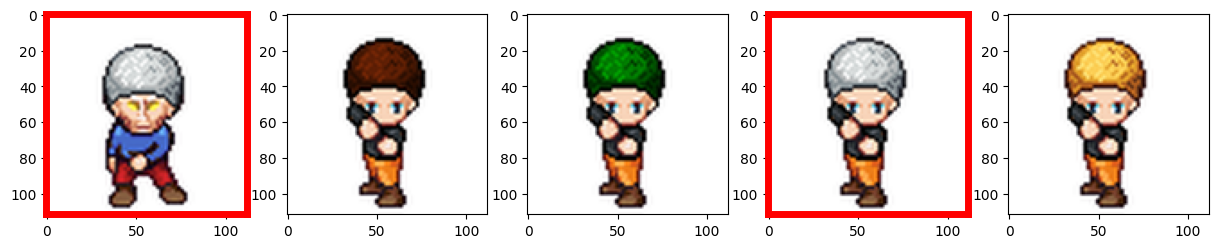

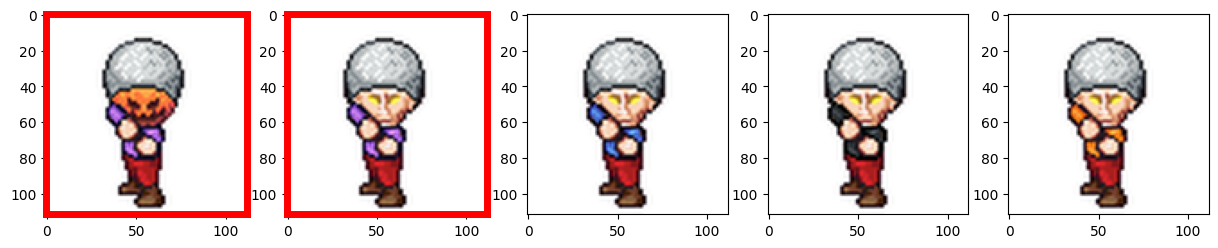

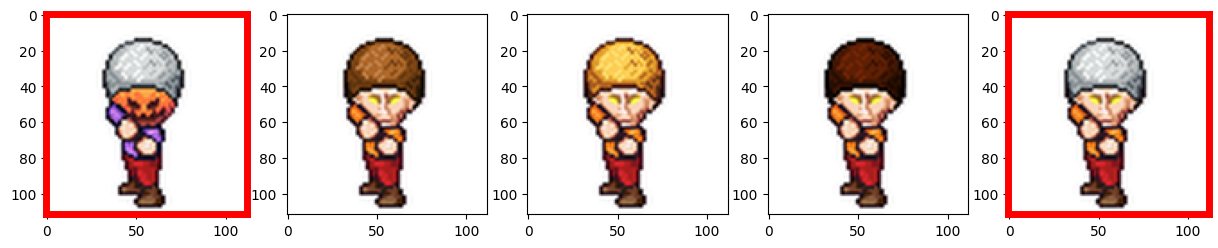

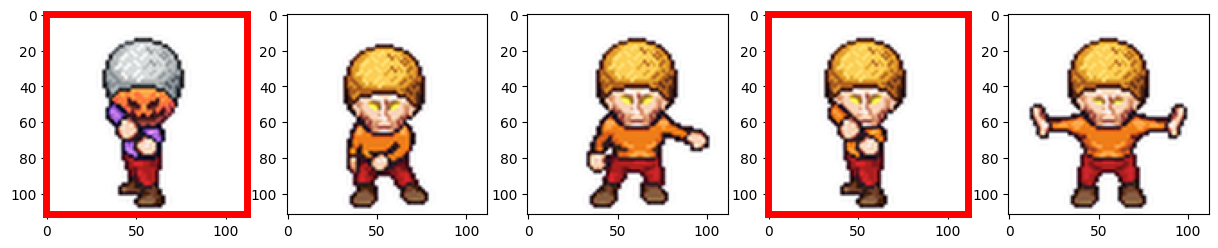

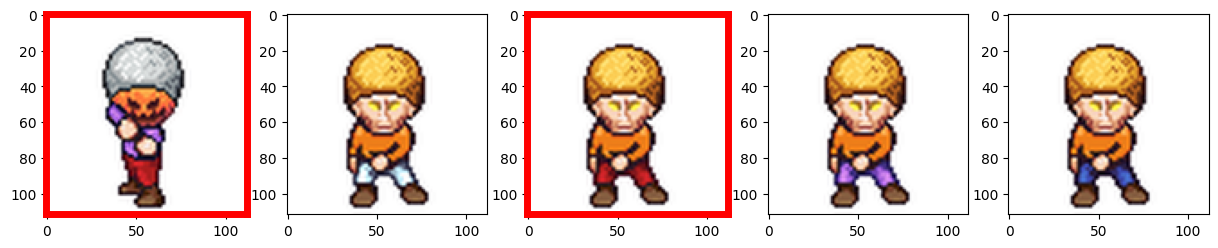

In [14]:
visualize_support_set(loader=train_dataloader, num_sets=3, support_size=support_size)

## Model


### training shallow shallow

In [15]:
encoder = CNNEncoder()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "model/" + dataset.lower() + " shallow shallow class.pt"

shallow_shallow_class = AspectBasedModel(represent_model=encoder, context_model = DeepSetTraversalModule, support_size=support_size)
shallow_shallow_class.to(device)

shallow_shallow_class.represent_model.requires_grad_(True)
optimizer = torch.optim.Adam(shallow_shallow_class.parameters(), lr=7e-4, weight_decay=1e-2)
criterion = AspectBasedTupletLoss(support_size, device=device)

In [16]:
if train_models:
  t_loss_context = train(shallow_shallow_class, train_dataloader, val_dataloader, 50, criterion, model_name=model_name)
else:
  shallow_shallow_class.load_state_dict(torch.load(model_name, map_location=device))
  shallow_shallow_class.eval()

### training VGG ResNet

In [17]:
encoder = VGG()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "model/" + dataset.lower() + " VGG resnet class.pt"

VGG_resnet_class = AspectBasedModel(represent_model=encoder, context_model = DeepSetTraversalModuleResnet, support_size=support_size)
VGG_resnet_class.to(device)

VGG_resnet_class.represent_model.requires_grad_(True)
optimizer = torch.optim.Adam(VGG_resnet_class.parameters(), lr=7e-4, weight_decay=1e-2)
criterion = AspectBasedTupletLoss(support_size, device=device)

In [18]:
if train_models:
  t_loss_context = train(VGG_resnet_class, train_dataloader, val_dataloader, 50, criterion, model_name=model_name)
else:
  VGG_resnet_class.load_state_dict(torch.load(model_name, map_location=device))
  VGG_resnet_class.eval()

### training Resnet ResNet

In [19]:
encoder = ResNet(ResidualBlock, [1,1])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "model/" + dataset.lower() + " resnet resnet class.pt"

ResNet_resnet_class = AspectBasedModel(represent_model=encoder, context_model = DeepSetTraversalModuleResnet, support_size=support_size)
ResNet_resnet_class.to(device)

ResNet_resnet_class.represent_model.requires_grad_(True)
optimizer = torch.optim.Adam(ResNet_resnet_class.parameters(), lr=7e-4, weight_decay=1e-2)
criterion = AspectBasedTupletLoss(support_size, device=device)

In [20]:
if train_models:
  t_loss_context = train(ResNet_resnet_class, train_dataloader, val_dataloader, 50, criterion, model_name=model_name)
else:
  ResNet_resnet_class.load_state_dict(torch.load(model_name, map_location=device))
  ResNet_resnet_class.eval()

# Test dataset

In [21]:
test_dataset = QuerySplitTest(attributes_test, df_attributes, images, same_aspect=same_aspect, data_queries = images_test, transform=transformations, support_size=support_size)
test_dataloader= DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=1)

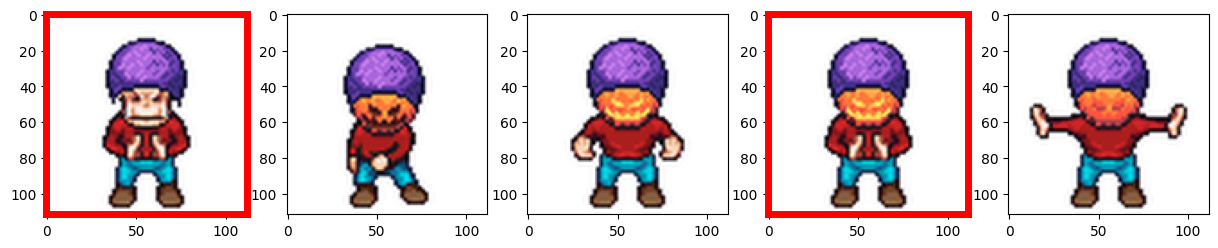

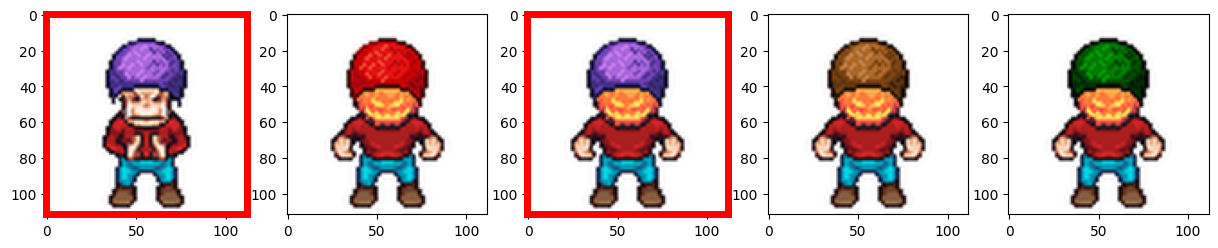

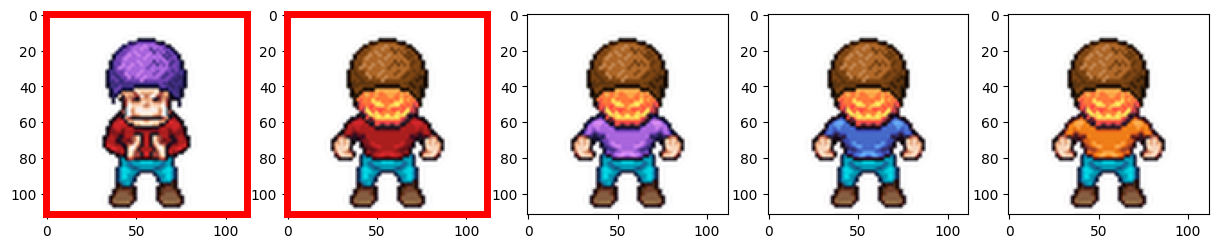

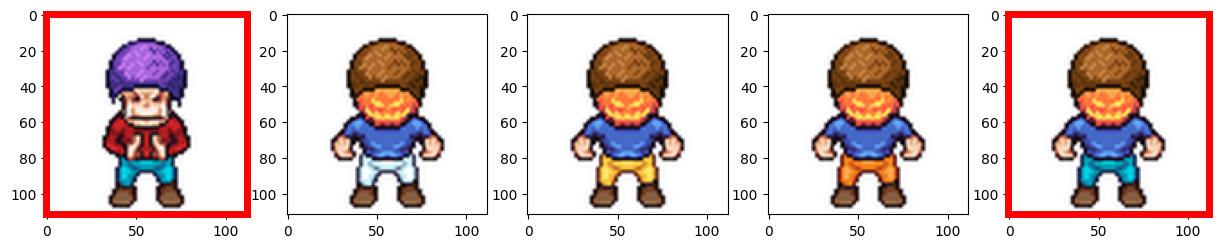

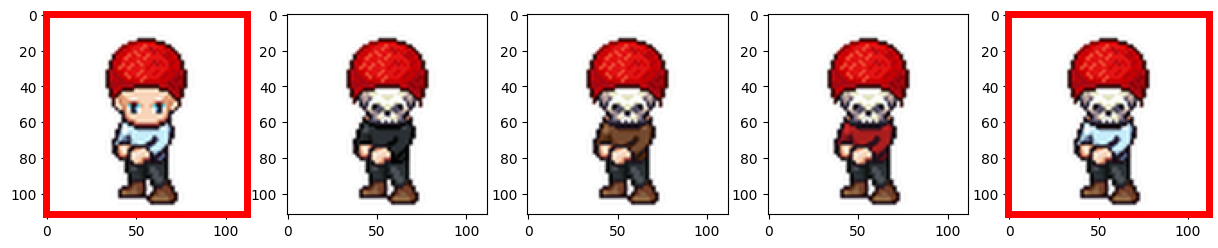

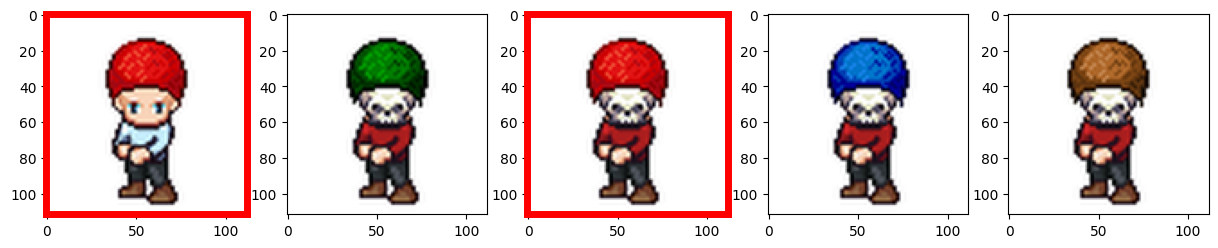

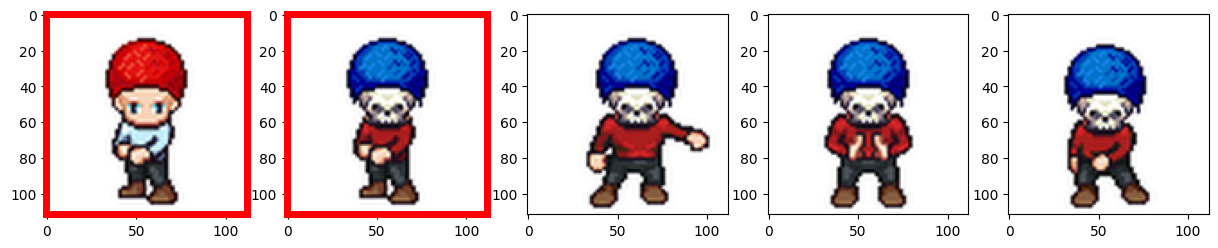

In [ ]:
visualize_support_set(loader=test_dataloader, num_sets=3, support_size=support_size)

## distance

In [ ]:
model_names = ['baseline', 'shallow_shallow', 'VGG_resnet', 'ResNet_resnet',
               'shallow_shallow_class', 'VGG_resnet_class', 'ResNet_resnet_class']

models = [baseline, shallow_shallow, VGG_resnet, ResNet_resnet, shallow_shallow_class,
          VGG_resnet_class, ResNet_resnet_class]

In [ ]:
def predict_distance(loader, num_runs, device, models, model_names, support_size):
    df_dist = pd.DataFrame()
    for i in range(num_runs):
        for anchor, support_sets, same_asp in loader:
            batch_size_tr = anchor.shape[0]
            anchor = anchor.to(device)

            for model_name, modelz in zip(model_names, models):
                new = pd.DataFrame()
                for j in range(support_size):
                    k=j+1
                    support = "support%d" % j
                    Y = "Y%d" % j
                    distancePD = 'distance%d' % k
                    support, labels = support_sets[support].to(device), support_sets[Y].to(device)
                    anchor_x, support_x = modelz(anchor, support)
                    anchor_x, support_x = anchor_x.view(batch_size_tr, -1), support_x.view(batch_size_tr, support_size, -1)

                    new[distancePD] = distance(anchor_x, support_x, support_size, device).cpu().detach().numpy().flatten()
                    Y = "Y%d" % k
                    new[Y] = labels.flatten()

                if model_name[-5:] == 'class':
                    new['split'] = 'class'
                    new['model'] = model_name[:-6]
                else:
                    new['split'] = 'query'
                    new['model'] = model_name

                for j in range(support_size):
                    k = j+1
                    aspect = 'aspect%d' % k
                    new[aspect] = np.repeat(same_asp[j], support_size)

                new['run'] = i

                df_dist = pd.concat([df_dist, new])
    return df_dist

In [ ]:
df_dist = predict_distance(test_dataloader, 1, device=device, models=models, model_names=model_names, support_size = support_size)

In [ ]:
pd.set_option('display.width', 150)
for i in range(support_size):
    j=i+1
    Y, dist, dista = "Y%d" % j, "dist%d" % j, "distance%d" % j
    print(interval_95(df_dist.groupby(['model', 'split', Y])[dista].agg(['mean', 'count', 'std'])))
    print('\n')


In [ ]:
dist_aspect1 = interval_95(df_dist.groupby(['model', 'split', 'aspect1', 'Y1'])['distance1'].agg(['mean', 'count', 'std']))
dist_aspect1